In [1]:
import numpy as np 
import scipy.stats as scistats
import scipy.io as sio 
from matplotlib import pyplot as plt 
import scipy.integrate as integrate


# Question 1

# Question 2

This question investigates rejection sampling. 

We do not know $p(\theta)$ and need to calculate $Z$. 

How do I go about selecting the proposal distribution? 

Part 3: compare to Question 1. 

Part 5: see how the number of samples influences the results. 

Discussions in bullet form. 

# Question 3

This question investigates importance sampling. 

# Question 4

Links to look at:
- https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo
- https://arxiv.org/pdf/1909.12313.pdf
- https://link.springer.com/article/10.3758/s13423-016-1015-8


This question focuses on using given samples to perform inference. The following linear hardening model was considered:
\begin{equation}
\sigma (\epsilon_n) = E \cdot \epsilon \cdot \left( 1 - h \left( \epsilon - \frac{\sigma_y}{E} \right) \right) + \left( \sigma_y + \frac{H \cdot E}{H + E} \right) \cdot \left( \epsilon - \frac{\sigma_y}{E} \right) \cdot h \left( \epsilon - \frac{\sigma_y}{E} \right) 
\end{equation}
with the unknown parameters of yield strength $\sigma_y$, plastic modulus $H$, and Young's modulus $E$. 

The measurements of the stress were modelled using:
\begin{equation} \label{eq: measure_model}
s_n = \sigma (\epsilon_n) + v_n
\end{equation}
where $\epsilon_n$ is the strain at measurement $n$; $\sigma (\epsilon)$ is the actual stress for the strain $\epsilon$; $v_n \tilde \mathcal{N} (0, \eta^2)$ and the standard deviation of the noise $\eta$ is 15. $s$ refers to the measurements and $\sigma$ refers to the prediction of the model. 

Markov Chain Monte Carlo (MCMC) was used to obtain the unknown parameters: samples from the posterior distribution over $E$, $\sigma_y$ and $H$. Therefore, the posterior samples were given in the provided dataset. 

MCMC methods are primarily used for calculating numerical approximations of multi-dimensional integrals. 

The acceptance rate of just over 20\% was assumed to be sufficent. 



### Given data

In [2]:
dataDict = sio.loadmat("mcmc_material_linear_hardening_N20.mat")
dataDict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'time_total', 'time_avg', 'acceptance_rate', 'acceptance_count', 'parm_samples', 'stress_m', 'strain_m', 'proposal_scaling', 'stddev_of_noise'])

In [3]:
print(dataDict["stddev_of_noise"])
print(dataDict["acceptance_rate"])
print(dataDict["acceptance_count"])

[[15]]
[[0.2303     0.22574    0.27546333]]
[[1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


Standard deviation of the noise: 15.0


Text(0, 0.5, "Young's modulus $E$")

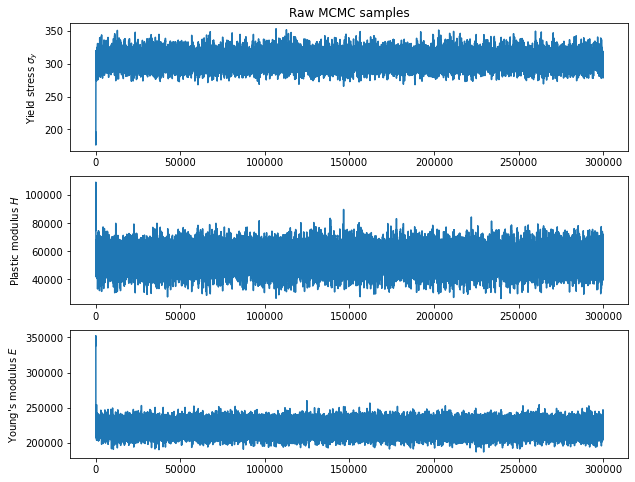

In [4]:

# These are the measurements available in the file: 
strain_m = dataDict["strain_m"].squeeze()
stress_m = dataDict["stress_m"].squeeze()

# These are the posterior samples:
parm_samples = dataDict["parm_samples"].squeeze()

# This is the standard deviation of the noise.
SIGMA = float(dataDict["stddev_of_noise"])
print("Standard deviation of the noise:", SIGMA)

def stress(e,sigma_y,H,E):
    h = lambda x: np.heaviside(x,1)
    sigma = E * e * (1 - h(e - sigma_y/E)) + (sigma_y + H * E/(H + E)*(e - sigma_y/E))*h(e - sigma_y/E)
    return sigma

plt.figure(1,figsize=(10,8))
plt.subplot(311)
plt.title("Raw MCMC samples")
plt.plot(parm_samples[:,0])
plt.ylabel("Yield stress $\sigma_y$")
plt.subplot(312)
plt.plot(parm_samples[:,1])
plt.ylabel("Plastic modulus $H$")
plt.subplot(313)
plt.plot(parm_samples[:,2])
plt.ylabel("Young's modulus $E$")



### Part 1

The given stress and strain measurements are plotted in Figure~\ref{ADD}, along with the stress-strain model using the following parameters: $\sigma_y = 300, H = 49000, E = 210000$.

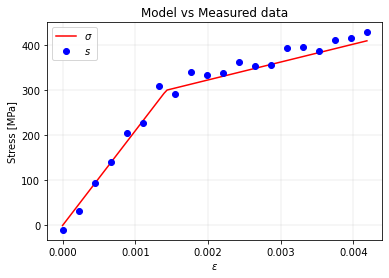

In [5]:

strain_model = np.linspace(0, strain_m[-1], 100)
sigma_y = 300
H = 49000
E = 210000

stress_model = stress(strain_model, sigma_y, H, E)

plt.figure(1)
plt.plot(strain_model, stress_model, 'r', label='$\sigma$')
plt.plot(strain_m, stress_m, 'bo', label='$s$')
plt.xlabel('$\epsilon$')
plt.ylabel('Stress [MPa]')
plt.title('Model vs Measured data')
plt.grid(linewidth=0.2)
plt.legend()


### Part 2

There are 3 unknown parameters: $E$, $\sigma_y$ and $H$, denoted by $\mathbf{\theta}$.

The likelihood function $p(s_n|\mathbf{\theta})$ measures how well the model, with the candidate parameters $\mathbf{\theta}$, fit the measured data, i.e. it measures the likelihood that the parameters and the model generated the observed data $s_n$.

If the data are independently and identically generated, the likelihood function can be written as:
\begin{equation}
\begin{aligned}
p(\mathbf{s} | \mathbf{\theta}) &= \prod_{n=1}^N \mathcal{N} (s_n | \mathbf{\theta}, 15^2) \\
&= \prod_{n=1}^N p_m (s_n | \mathbf{\theta})
\end{aligned}
\end{equation}

and the log-likelihood can be written as:
\begin{equation}
log \; p(\mathbf{s} | \mathbf{\theta}) = \sum_{n=1}^N log \; p_m (s_n | \mathbf{\theta})
\end{equation}

It must be noted that the likelihood function is not a distribution over $\mathbf{\theta}$.

The log-likelihood of the model given by Equation~\ref{eq: measure_model} was calculated using the given parameter values.

In [6]:
parameters = [300, 49000, 210000]

def log_likelihood(measured_strain, measured_stress, parm): 
    sigma_y, H, E = parm[0], parm[1], parm[2]
    Z = len(measured_strain)
    
    ll = 0
    for n in range(Z):
        mean = stress(measured_strain[n], sigma_y, H, E)
        std = SIGMA
        log_of_height = scistats.norm.logpdf(measured_stress[n], mean, std) # log of PDF
        ll += log_of_height
    
    return ll


In [7]:

log_like = log_likelihood(strain_m, stress_m, parameters)
print("Log-likelihood:", log_like)


Log-likelihood: -85.01133484296402


### Part 3

Samples have been provided. They were drawn from the unnormalised posterior distribution. In the sample generating process, variance is important as it determines the range from which samples are taken. It may be too large, therefore, proposing unsensible samples. This highlights the importance of the parameter tuning process. Smaller variance will increase correlation. 

The following empirical posterior marginal distributions were obtained using all of the given samples:

(Would be nice to compare MCMC with grid-based solution but have not done that and do not think it is expected)

Text(0, 0.5, 'Density')

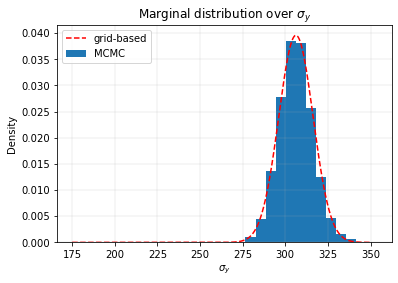

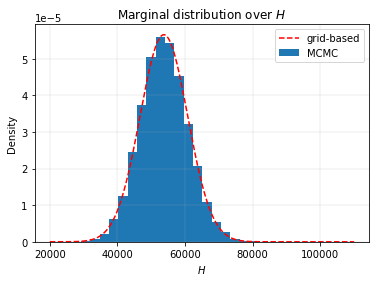

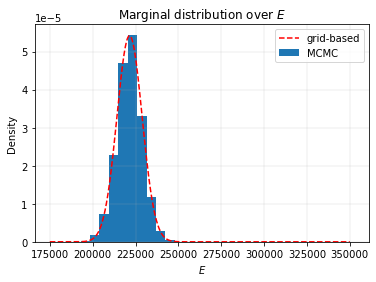

In [8]:

yield_stress_samples = parm_samples[:,0]
H_samples = parm_samples[:,1]
E_samples = parm_samples[:,2]

var_yield = np.var(yield_stress_samples)
var_H = np.var(H_samples)
var_E = np.var(E_samples)

yield_grid = np.linspace(175, 350, 10000)
yield_distrib = scistats.norm.pdf(yield_grid, loc=np.mean(yield_stress_samples), scale=np.sqrt(var_yield))

H_grid = np.linspace(20000, 110000, 10000)
H_distrib = scistats.norm.pdf(H_grid, loc=np.mean(H_samples), scale=np.sqrt(var_H))

E_grid = np.linspace(175000, 350000, 10000)
E_distrib = scistats.norm.pdf(E_grid, loc=np.mean(E_samples), scale=np.sqrt(var_E))


# YIELD STRESS
plt.figure(1)
plt.grid(linewidth=0.2)
plt.plot(yield_grid, yield_distrib, 'r--', label="grid-based")
plt.hist(yield_stress_samples,density=True,bins=30, label='MCMC')
plt.title(r"Marginal distribution over $\sigma_y$")
plt.legend()
plt.xlabel(r"$\sigma_y$")
plt.ylabel("Density")

# PLASTIC MODULUS
plt.figure(2)
plt.grid(linewidth=0.2)
plt.plot(H_grid, H_distrib, 'r--', label="grid-based")
plt.hist(H_samples,density=True,bins=30, label='MCMC')
plt.title(r"Marginal distribution over $H$")
plt.legend()
plt.xlabel(r"$H$")
plt.ylabel("Density")

# ELASTIC MODULUS
plt.figure(3)
plt.grid(linewidth=0.2)
plt.plot(E_grid, E_distrib, 'r--', label="grid-based")
plt.hist(E_samples,density=True,bins=30, label='MCMC')
plt.title(r"Marginal distribution over $E$")
plt.legend()
plt.xlabel(r"$E$")
plt.ylabel("Density")



Additionally, the correlation between each signal and itself was calculated. The shifts ('noise') around zero refer to estimation errors. The figures below show that the samples for each are mostly correlated with themselves and there is not much structure in the correlation.

MAKE SURE ABOUT THIS: (The example in the demo looks similar to this but he says it is highly correlated?) (Would be good if can plot the grid-based solution as he uses this to compare and to support correlation)

Therefore, it was found that the samples were uncorrelated. This is shown by the original sample plots that indicate the samples were likely independently sampled and they are shown to rapidly converge to the domain of the actual solution. This is also highlighted by the sensible marginal distribution histograms that seem to represent the expected Gaussian distributions.  



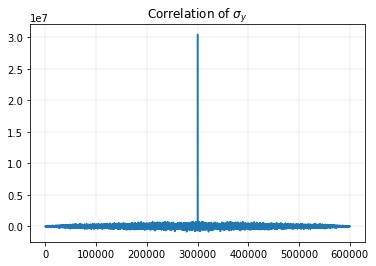

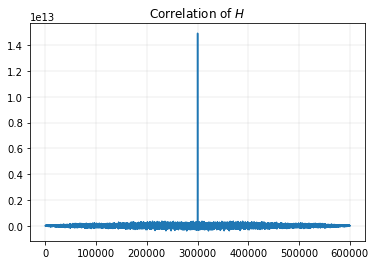

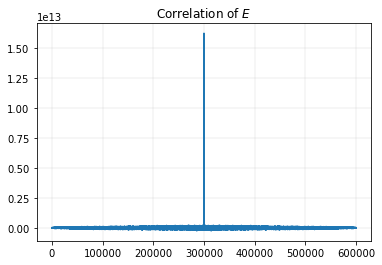

In [9]:

import scipy.signal as scisig

corr_sigma_y = scisig.correlate(yield_stress_samples-np.mean(yield_stress_samples),yield_stress_samples-np.mean(yield_stress_samples))
corr_H = scisig.correlate(H_samples-np.mean(H_samples),H_samples-np.mean(H_samples))
corr_E = scisig.correlate(E_samples-np.mean(E_samples),E_samples-np.mean(E_samples))

plt.figure(1)
plt.plot(corr_sigma_y)
plt.title(r"Correlation of $\sigma_y$")
plt.grid(linewidth=0.2)

plt.figure(2)
plt.plot(corr_H)
plt.title(r"Correlation of $H$")
plt.grid(linewidth=0.2)

plt.figure(3)
plt.plot(corr_E)
plt.title(r"Correlation of $E$")
plt.grid(linewidth=0.2)




It was decided to investigate using a subset of the samples (ignoring the burn-in period), as well as thinning. Thinning of samples is used to remove correlation.

Case 1:
- Subset of samples from 150000 to 300000 (50\%).
- Thinning of this subset, taking every 10th sample.

Implementing Case 1 showed to have a negligible affect on the marginal distributions. A small improvement is made in the distributions' relation to a Gaussian. This supports that the samples were not highly correlated.   

Taking larger steps in the case of thinning the sample subset of Case 1 generally provided inaccurate distributions with larger variations and less relation to a Gaussian.

Furthermore, decreasing the size of the sample subset only resulted in distribution deviations when the subset was approximately smaller than 30000 (10\% of total).   


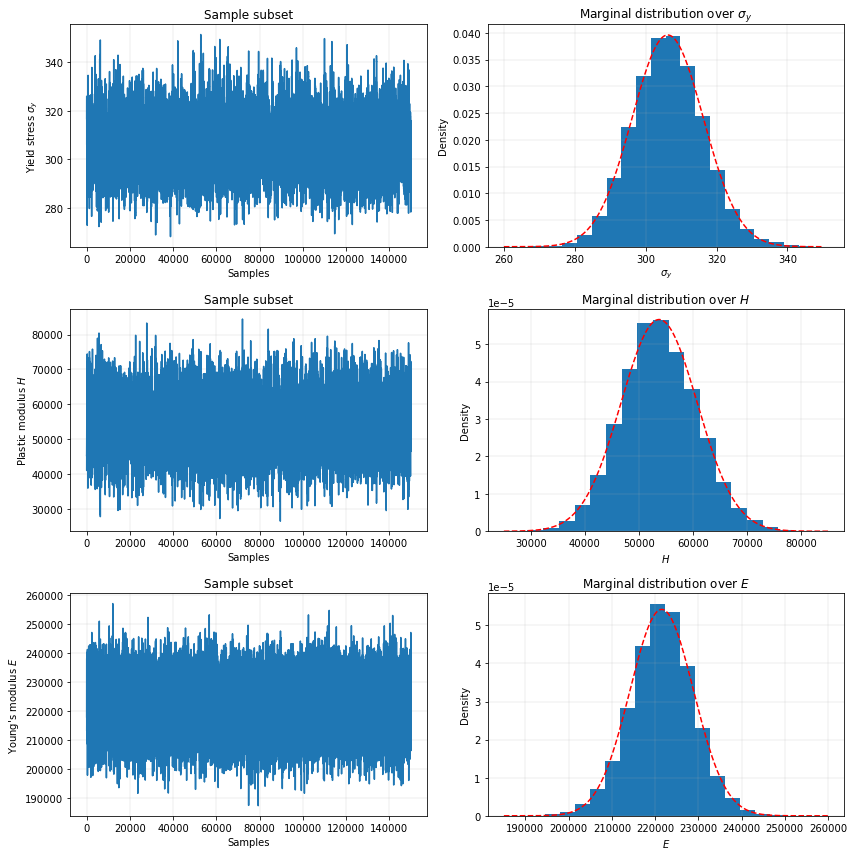

In [10]:
# Again, it would be good to superimpose the grid-based solutions. 

index = np.arange(150000,300000) # Using a subset of the samples  
# index = np.arange(150000,300000)[::10] # With thinning

# print(len(index))

yield_grid = np.linspace(260, 350, 10000)
yield_distrib = scistats.norm.pdf(yield_grid, loc=np.mean(yield_stress_samples), scale=np.sqrt(var_yield))
H_grid = np.linspace(25000, 85000, 10000)
H_distrib = scistats.norm.pdf(H_grid, loc=np.mean(H_samples), scale=np.sqrt(var_H))
E_grid = np.linspace(185000, 260000, 10000)
E_distrib = scistats.norm.pdf(E_grid, loc=np.mean(E_samples), scale=np.sqrt(var_E))



fig1, axs1 = plt.subplots(3, 2, figsize=(12,12))
axs1[0][0].plot(yield_stress_samples[index])
axs1[0][0].set_xlabel('Samples')
axs1[0][0].set_ylabel("Yield stress $\sigma_y$")
axs1[0][0].set_title('Sample subset')
axs1[0][0].grid(linewidth=0.2)
axs1[0][1].hist(yield_stress_samples[index], density=True, bins=20)
axs1[0][1].plot(yield_grid, yield_distrib, 'r--')
axs1[0][1].set_xlabel(r"$\sigma_y$")
axs1[0][1].set_ylabel("Density")
axs1[0][1].set_title(r"Marginal distribution over $\sigma_y$")
axs1[0][1].grid(linewidth=0.2)

axs1[1][0].plot(H_samples[index])
axs1[1][0].set_xlabel('Samples')
axs1[1][0].set_ylabel("Plastic modulus $H$")
axs1[1][0].set_title('Sample subset')
axs1[1][0].grid(linewidth=0.2)
axs1[1][1].hist(H_samples[index], density=True, bins=20)
axs1[1][1].plot(H_grid, H_distrib, 'r--')
axs1[1][1].set_xlabel(r"$H$")
axs1[1][1].set_ylabel("Density")
axs1[1][1].set_title(r"Marginal distribution over $H$")
axs1[1][1].grid(linewidth=0.2)

axs1[2][0].plot(E_samples[index])
axs1[2][0].set_xlabel('Samples')
axs1[2][0].set_ylabel("Young's modulus $E$")
axs1[2][0].set_title('Sample subset')
axs1[2][0].grid(linewidth=0.2)
axs1[2][1].hist(E_samples[index], density=True, bins=20)
axs1[2][1].plot(E_grid, E_distrib, 'r--')
axs1[2][1].set_xlabel(r"$E$")
axs1[2][1].set_ylabel("Density")
axs1[2][1].set_title(r"Marginal distribution over $E$")
axs1[2][1].grid(linewidth=0.2)

fig1.tight_layout()
# plt.savefig('')


Text(0, 0.5, 'Density')

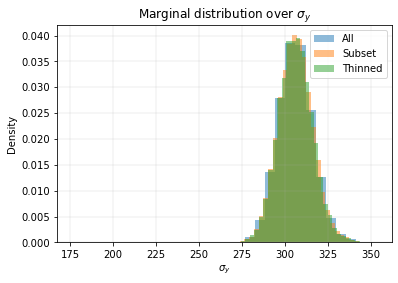

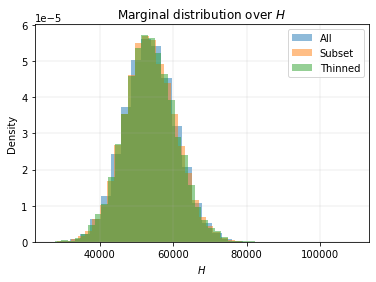

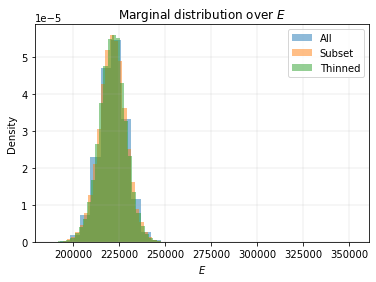

In [11]:
index = np.arange(150000,300000) # Using a subset of the samples
index2 = np.arange(150000,300000)[::10] # With thinning

# YIELD STRESS
plt.figure(1)
plt.grid(linewidth=0.2)
# maybe add grid-based solution
plt.hist(yield_stress_samples,density=True,bins=30, alpha=0.5, label='All')
plt.hist(yield_stress_samples[index],density=True,bins=30, alpha=0.5, label='Subset')
plt.hist(yield_stress_samples[index2],density=True,bins=30, alpha=0.5, label='Thinned')
plt.title(r"Marginal distribution over $\sigma_y$")
plt.legend()
plt.xlabel(r"$\sigma_y$")
plt.ylabel("Density")

# PLASTIC MODULUS
plt.figure(2)
plt.grid(linewidth=0.2)
# maybe add grid-based solution
plt.hist(H_samples,density=True,bins=30, alpha=0.5, label='All')
plt.hist(H_samples[index],density=True,bins=30, alpha=0.5, label='Subset')
plt.hist(H_samples[index2],density=True,bins=30, alpha=0.5, label='Thinned')
plt.title(r"Marginal distribution over $H$")
plt.legend()
plt.xlabel(r"$H$")
plt.ylabel("Density")

# ELASTIC MODULUS
plt.figure(3)
plt.grid(linewidth=0.2)
# maybe add grid-based solution
plt.hist(E_samples,density=True,bins=30, alpha=0.5, label='All')
plt.hist(E_samples[index],density=True,bins=30, alpha=0.5, label='Subset')
plt.hist(E_samples[index2],density=True,bins=30, alpha=0.5, label='Thinned')
plt.title(r"Marginal distribution over $E$")
plt.legend()
plt.xlabel(r"$E$")
plt.ylabel("Density")



### Part 4

$\mathbb{E} \{ \sigma_y \mid \mathbf{\epsilon}, \mathbf{\sigma} \}$, $\mathbb{E} \{ H \mid \mathbf{\epsilon}, \mathbf{\sigma} \}$ and $\mathbb{E} \{ E \mid \mathbf{\epsilon}, \mathbf{\sigma} \}$ were calculated using Monte Carlo integration. This was done with the given samples.  

For example:
\begin{equation}
\mathbb{E} \{{E}\} = \frac{1}{N} \sum_i^N E_i
\end{equation}

Ignoring the burn-in period and making use of thinning could result in slightly increased accuracy.

What is the analytical solution?

Current results:
- 1st value = all samples.
- 2nd value = subset of samples.
- 3rd value = thinned subset.

In [12]:

# ESTIMATES:
print("Expected value estimate of yield stress:   ", np.mean(yield_stress_samples), np.mean(yield_stress_samples[index]),
     np.mean(yield_stress_samples[index2]))

print("Expected value estimate of plastic modulus:", np.mean(H_samples), np.mean(H_samples[index]),
     np.mean(H_samples[index2]))

print("Expected value estimate of Young's modulus:", np.mean(E_samples), np.mean(E_samples[index]),
     np.mean(E_samples[index2]))





Expected value estimate of yield stress:    306.214692641026 306.3307257624954 306.3282521725974
Expected value estimate of plastic modulus: 53728.257905879545 53681.961482316474 53696.84950198777
Expected value estimate of Young's modulus: 221514.7318665411 221451.73031061943 221518.58392888092


### Part 5

The covariance matrix of the posterior samples was calculated. The posterior samples are given. 

The unbiased estimator of the covariance matrix was given by
\begin{equation}
\hat{\mathbf{\Sigma}} = \frac{1}{N-1} \sum_{n=1}^N (\mathbf{x}_n - \hat{\mathbf{\mu}}) (\mathbf{x}_n - \hat{\mathbf{\mu}})^T
\end{equation}

where $\mathbf{x}$ refers to the samples and $\hat{\mathbf{\mu}}$ refers to the mean of the samples.

The covariance matrix was calculated as: ADD.

Therefore, the different variables were negatively correlated with each other. An increase in the yield strength will result in a decreased plastic modulus. DOES IT MAKES SENSE FOR THE DATA AND MODEL?

Figure~\ref{ADD} confirms that the yield strength and plastic modulus are negatively correlated (caption: Illustrating the negative correlation between the plastic modulus and yield strength samples). 

Covariance matrix:
[[ 1.01558548e+02 -5.73853064e+04 -1.87374486e+04]
 [-5.73853064e+04  4.97612283e+07 -2.62052073e+06]
 [-1.87374486e+04 -2.62052073e+06  5.42008327e+07]]


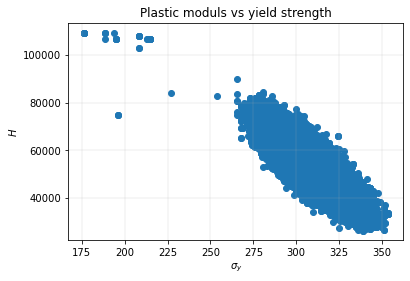

In [13]:
covariance = np.cov(parm_samples, rowvar=False)
print("Covariance matrix:")
print(covariance)


plt.figure(1)
plt.scatter(yield_stress_samples, H_samples)
plt.xlabel('$\sigma_y$')
plt.ylabel('$H$')
plt.title('Plastic moduls vs yield strength')
plt.grid(linewidth=0.2)

### Part 6

Need to plot the mean with bounds (+- 3 std or 5th and 95 percentiles). The mean was taken from the 50\% subset of the samples (ignoring the burn-in period). 

Document the procedure that was used to obtain the posterior predictive distribution.

In [14]:

sigma_y_5 = np.percentile(yield_stress_samples,5)
sigma_y_95 = np.percentile(yield_stress_samples,95)

H_5 = np.percentile(H_samples,5)
H_95 = np.percentile(H_samples,95)

E_5 = np.percentile(E_samples,5)
E_95 = np.percentile(E_samples,95)

print("Yield strength")
print("Mean =", np.mean(yield_stress_samples))
print(sigma_y_5, sigma_y_95)
print("")
print("Plastic modulus")
print("Mean =", np.mean(H_samples))
print(H_5, H_95)
print("")
print("Young's modulus")
print("Mean =", np.mean(E_samples))
print(E_5, E_95)
print("")


Yield strength
Mean = 306.214692641026
290.31511952855385 322.9499197153924

Plastic modulus
Mean = 53728.257905879545
42348.7994019187 65407.40517375437

Young's modulus
Mean = 221514.7318665411
209301.89881809443 233320.11302684594



#### Does not seem correct...

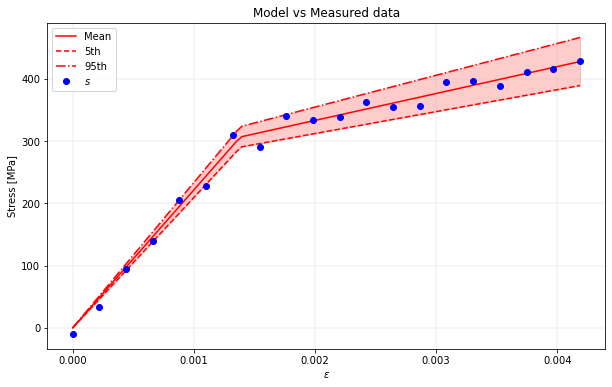

In [15]:
strain_model = np.linspace(0, strain_m[-1], 100)

# Mean
sigma_y = np.mean(yield_stress_samples[index])
H = np.mean(H_samples[index])
E = np.mean(E_samples[index])
model_mean = stress(strain_model, sigma_y, H, E)

#percentiles 
sigma_y_5 = np.percentile(yield_stress_samples,5)
sigma_y_95 = np.percentile(yield_stress_samples,95)

H_5 = np.percentile(H_samples,5)
H_95 = np.percentile(H_samples,95)

E_5 = np.percentile(E_samples,5)
E_95 = np.percentile(E_samples,95)

# 5th
model_5th = stress(strain_model, sigma_y_5, H_5, E_5)

# 95th
model_95th = stress(strain_model, sigma_y_95, H_95, E_95)

plt.figure(1, (10, 6))
# plt.plot(strain_model, stress_model, 'r', label='$\sigma$')
plt.plot(strain_model, model_mean, 'r', label='Mean')
plt.plot(strain_model, model_5th, 'r--', label='5th')
plt.plot(strain_model, model_95th, 'r-.', label='95th')
plt.fill_between(strain_model, model_5th, model_95th, color="r", alpha = 0.2)  
plt.plot(strain_m, stress_m, 'bo', label='$s$')
plt.xlabel('$\epsilon$')
plt.ylabel('Stress [MPa]')
plt.title('Model vs Measured data')
plt.grid(linewidth=0.2)
plt.legend()




#### Does not seem correct...


117.90729464889553


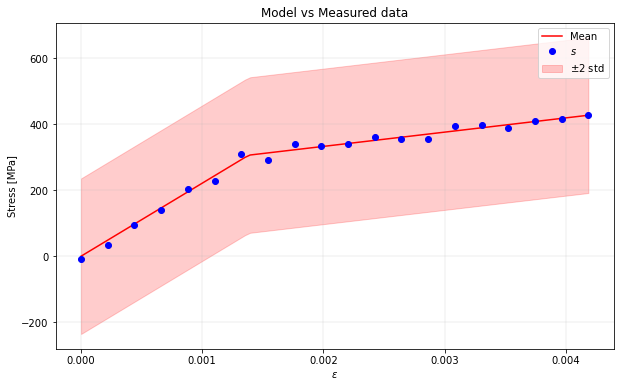

In [16]:

strain_model = np.linspace(0, strain_m[-1], 100)

# Mean
sigma_y = np.mean(yield_stress_samples[index])
H = np.mean(H_samples[index])
E = np.mean(E_samples[index])
model_mean = stress(strain_model, sigma_y, H, E)

std = np.std(model_mean)
print(std)

plt.figure(2, (10, 6))
plt.plot(strain_model, model_mean, 'r', label='Mean')
plt.fill_between(strain_model, model_mean-2*std, model_mean+2*std, color="r", alpha = 0.2, label='$\pm$2 std')  
plt.plot(strain_m, stress_m, 'bo', label='$s$')
plt.xlabel('$\epsilon$')
plt.ylabel('Stress [MPa]')
plt.title('Model vs Measured data')
plt.grid(linewidth=0.2)
plt.legend()



# std = []
# to_sum = []
# for i in range(20):
#     to_sum.append((stress_m[i]-model_mean[i])**2)
#     pop = i+1
#     std_val = np.sqrt(np.sum(to_sum)/pop)
#     std.append(std_val)
    
# print(std)



### Part 7

The following probability was calculated:
\begin{equation*}
P (\sigma_y > 300 \mid \epsilon = 0.002, \mathbf{\epsilon}, \mathbf{\sigma})
\end{equation*}

Therefore, given the observed historical data and strain $\epsilon = 0.002$, the probability of $\sigma_y$ being greater than 300 was required.

Since $\sigma_y$ is one of the unknown parameters, it lies in the parameter space. Therefore, the probability would be evaluated using the posterior distribution by marginalising over $H$ and $E$ to obtain a probability distribution over $\sigma_y$ and then using $scistats.norm.cdf$. However, in this case, the empirical marginal distribution has already been determined from the given posterior samples.

The marginal distribution over $\sigma_y$ is given by:
\begin{equation}
p(\sigma_y) = \int_{H} \int_{E} p(\sigma_y, H, E) \; dE \; dH
\end{equation}

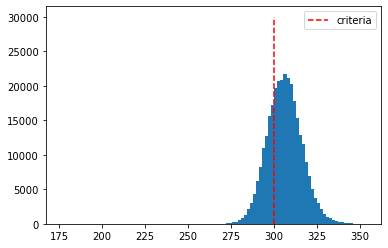

<IPython.core.display.Latex object>

In [17]:
from IPython.display import display, Latex

yield_stress = yield_stress_samples[::50]
theta = np.linspace(300,350,len(yield_stress))

plt.hist(yield_stress_samples,bins=100)
plt.plot([300,300],[0,30000],'r--',label='criteria')
plt.legend()
plt.show()

pdf1,_,_ = plt.hist(yield_stress,bins=theta,density=False) 
plt.close()

proba = np.sum(pdf1)/len(pdf1)
            
display(Latex(r'Using MC Integration $P (\sigma_y > 300 \mid \epsilon = 0.002, \mathbf{\epsilon}, \mathbf{\sigma})$ = '+str(proba)))

### Part 8

The following probability was calculated:
\begin{equation*}
P (\sigma > 300 \mid \epsilon = 0.002, \mathbf{\epsilon}, \mathbf{\sigma})
\end{equation*}

Therefore, given the observed historical data and strain $\epsilon = 0.002$, the probability of $\sigma$ being greater than 300 was required.

Since $\sigma$ is composed of the three unknown parameters, it lies in the parameter space.

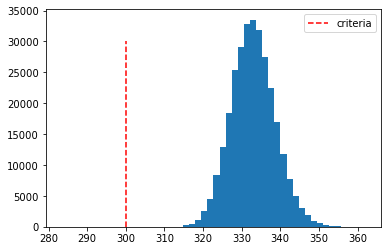

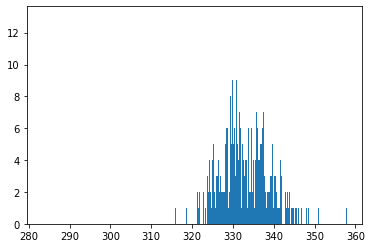

<IPython.core.display.Latex object>

In [18]:
def stress(e,sigma_y,H,E):
    h = lambda x: np.heaviside(x,1)
    sigma = E * e * (1 - h(e - sigma_y/E)) + (sigma_y + H * E/(H + E)*(e - sigma_y/E))*h(e - sigma_y/E)
    return sigma

sigma = stress(0.002,yield_stress_samples, H_samples, E_samples) 

plt.hist(sigma,bins=50)
plt.plot([300,300],[0,30000],'r--',label='criteria')
plt.legend()
plt.show()

pdf1,_,_ = plt.hist(sigma[::50],bins=len(sigma[::50]),density=False) 
plt.close()

proba = np.sum(pdf1)/len(pdf1)
            
display(Latex(r'Using MC Integration $P (\sigma > 300 \mid \epsilon = 0.002, \mathbf{\epsilon}, \mathbf{\sigma})$ = '+str(proba)))

### Part 9

The following probability was calculated:
\begin{equation*}
P (s > 300 \mid \epsilon = 0.002, \mathbf{\epsilon}, \mathbf{\sigma})
\end{equation*}

Therefore, given the historical data and strain $\epsilon = 0.002$, the probability of a new data point $s$ being greater than 300 was required.

Since $s$ is the measurement variable, it lies in the data space. Therefore, the probability was evaluated using the posterior predictive distribution. For a grid-based approach, the $pdf$ over $s$ would obtained for $\epsilon = 0.002$ and then the $cdf$ thereof would be constructed. However, samples from the posterior distribution were provided. EXPLAIN HOW TO GET RESULT. 

The resulting probability was calculated as ADD.

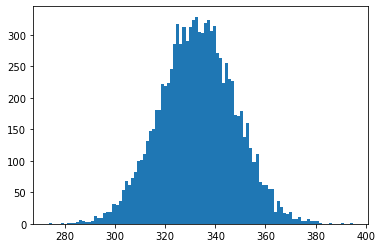

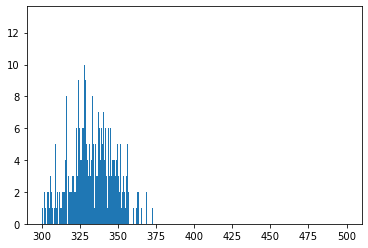

<IPython.core.display.Latex object>

In [51]:
model_mean = stress(0.002, sigma_y, H, E)

s_model = scistats.norm.rvs(loc=model_mean,scale=15,size=10000)
plt.hist(s_model,bins=100)
plt.plot([300,300],[0,0.039],'r--',label='criteria')
plt.show()

theta = np.linspace(300,500,len(s_model))

pdf1,_,_ = plt.hist(s_model,theta,density=False) 
plt.show()

proba = np.sum(pdf1)/len(pdf1)
            
display(Latex(r'Using MC Integration $P (s > 300 \mid \epsilon = 0.002, \mathbf{\epsilon}, \mathbf{\sigma})$ = '+str(proba)))

### Part 10


Short discussion is expected. Must be able to detail the difference between Part 8 and Part 9 ($\sigma$ vs $s$). What do they quantify?

The probability in Part 7 refers to the unknown parameter $\sigma_y$, which lies in the parameter space. The probability in Part 8 refers to the prediction of the model $\sigma$ comprising the unknown variables $\sigma_y$, $H$ and $E$. Therefore, the prediction of the model also lies in the parameter space (MAKE SURE?). The probability in Part 9 refers to the measurement variable $s$, which lies in the data space. The data space takes into account the variance in the model and the additional noise.   

# Question 5

Note: Rejection sampling and MCMC demos were supplied during the lecture.

This question investigates Markov Chain Monte Carlo. The matropolis algorithm would need to be used (can also try matropolis-hastings algorithm).  

The likelihood function must be in the form provided below. 

For Part 5, mention the following. It must be noted that probability statements can now easily be calculated without even knowing what the model evidence is. Therefore, one does not need to integrate to use the model. Monte Carlo integration was used to calculate the following probability:
\begin{equation}
P (\theta > 2 \mid \mathbf{x}) 
\end{equation}

For Part 6, investigate the effect of making the variance (given as $1^2$) larger. How does this affect the acceptance rate and the calculated probability in Part 5. 

Document the acceptance ratio. 


In [20]:

def log_likelihood(theta,x): 
    
    pass

# You are going to use this function in the MCMC calculation:
def log_unnorm_post(theta,x):
    
    pass


# Question 6

